In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
import uproot

In [17]:
datapath = "/home/haue/repositories/Masters/data/pad_calibration/"
ch_file = datapath+"padmatcher_peaks.txt"
cal_file = datapath+"padcalc_peaks.txt"

In [18]:
dtype = [('detector', 'U10'), ('channel', 'i4'), ('xvalue', 'i4'), ('mean', 'f8'), ('sigma', 'f8')]

ch_data = np.genfromtxt(ch_file, dtype=dtype, encoding=None)
cal_data = np.genfromtxt(cal_file, dtype=dtype, encoding=None)
# Access each column using field names:

ch_means = ch_data['mean']
ch_sigmas = ch_data['sigma']
cal_means = cal_data['mean']
cal_sigmas = cal_data['sigma']

nrpeaks = 4

def lin(x, a, b):
    return a*x+b

Calibration values for P1
-338.06504074139076 3.481816316328987
[-0.53546022  0.8730384  -0.33757822]

Calibration values for P2
-295.3267480732326 3.094318712888462
[-3.07230757  5.10316947 -2.03086222]

Calibration values for P3
-304.378816250088 3.1674153475152966
[-1.12399886  1.84169761 -0.71769863]

Calibration values for P6
-314.69664693042847 3.177795744224188
[-3.14876623  5.23237031 -2.08360423]



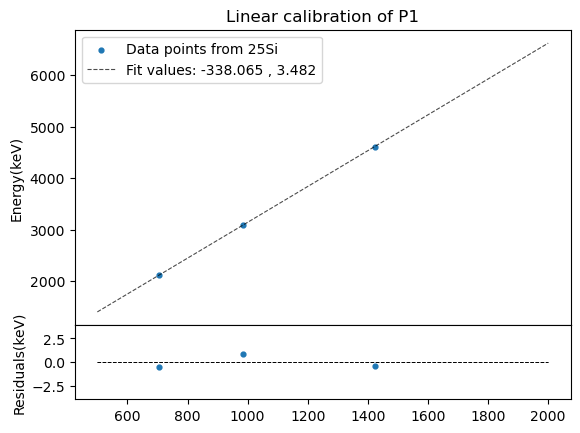

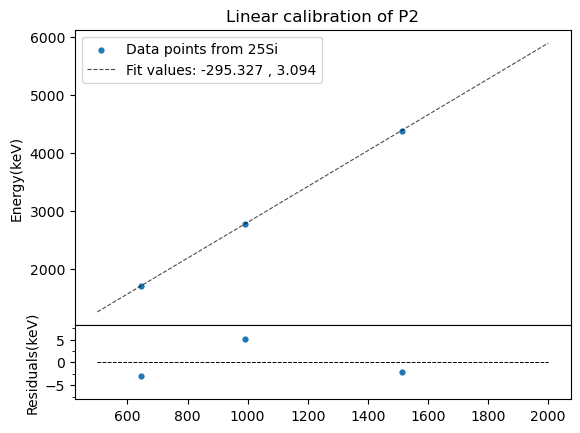

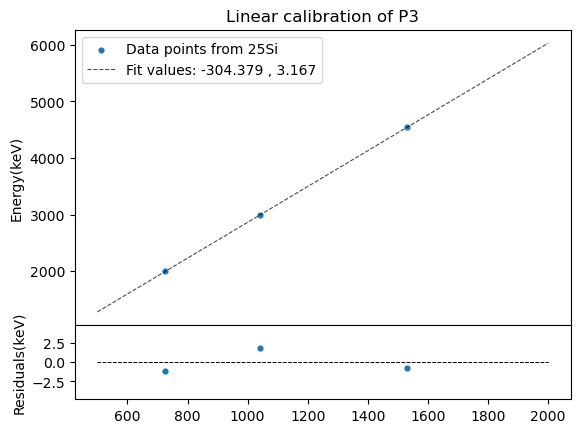

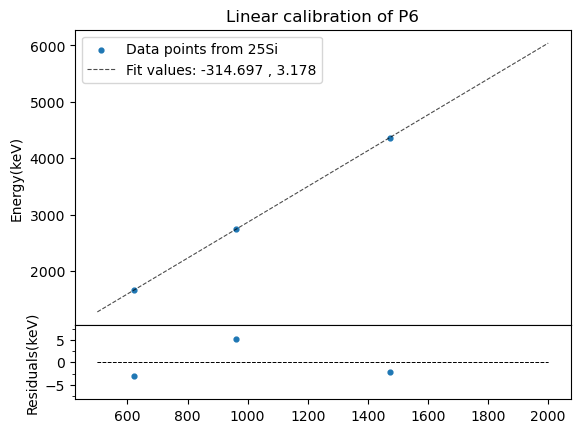

In [25]:
resis = np.array([])
avals = np.array([])
bvals = np.array([])
mask_to_keep = np.array([True, True, False, True])
for i in range(1,5):
    ch_x = ch_means[nrpeaks*(i-1):nrpeaks*i]
    cal_x = cal_means[nrpeaks*(i-1):nrpeaks*i]
    ch_x = ch_x[mask_to_keep]
    cal_x = cal_x[mask_to_keep]
    pad = f"P{i}"
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0}, sharex=True)
    ax1, ax2 = axs
    
    popt, _ = sc.curve_fit(lin, ch_x, cal_x)
    
    xs = np.linspace(500, 2000)
    fitvals = lin(ch_x, popt[0], popt[1])
    resi = cal_x-fitvals
    ax1.scatter(ch_x, cal_x, s=12, label="Data points from 25Si")
    ax1.plot(xs,lin(xs, popt[0], popt[1]), ls='--',color='k', alpha=0.7, lw=0.8,label=f"Fit values: {np.round(popt[1], 3)} , {np.round(popt[0], 3)}")
    ax1.set_xlabel("Channel")
    ax1.set_ylabel("Energy(keV)")
    if i==4:
        pad = "P6"
    ax1.set_title(f"Linear calibration of {pad}")
    ax1.legend()
    
    ax2.hlines(0, 500,2000, color='grey', ls='--', lw=0.7)
    ax2.scatter(ch_x, resi, s=12)
    #ax2.legend(fontsize='x-small', loc='lower right')
    ax2.hlines(0, 500, 2000, ls='--', color='k', lw=0.7) 
    ax2.set_yticks(np.arange(-15,15,2.5), minor=True)
    ax2.set_ylim(-np.max(np.abs(resi))-3, np.max(np.abs(resi))+3)
    ax2.set_ylabel("Residuals(keV)")
    print(f"Calibration values for {pad}")
    print(popt[1], popt[0])
    print(resi)
    print()
    resis=np.append(resis, resi)
    avals=np.append(avals, popt[0])
    bvals=np.append(bvals, popt[1])
    
    
#-364.72004274357744 3.496200297901778
#-285.96409610289203 3.0793560775868785
#-314.8331916517445 3.1678775582667975
#-346.640676469352 3.196578063168012
#avals

In [33]:
### Rel between proton and alphas
## from the below alpha cal of P6 -334.0105837901541 3.1435126747885684
alpha_a_after = np.array([3.43217, 3.04866, 3.12587, 3.1332])#3.1435126747885684])
alpha_b_after = np.array([-332.31, -286.844, -297.603, -317.845])#-334.0104837901541])
alpha_a_before = np.array([3.43566, 3.04866, 3.12772, 3.14001])#3.1435126747885684])
alpha_b_before = np.array([-333.155, -285.846, -300.269, -326.079])#-334.0104837901541])
relative_a_aa = alpha_a_after/alpha_a_before
relative_b_aa = alpha_b_after/alpha_b_before
print("Relative differences between after the experiment and beore the experiment of the pad detectors")
for i in list(zip(relative_a_aa,relative_b_aa)):
    print(i)
print()
print("Relative differences between the proton calibration and the alpha calibration")
print("The commenly referred value is 1.014")
relative_a_pa = avals/alpha_a_after
relative_b_pa = bvals/alpha_b_after
for j in list(zip(relative_a_pa,relative_b_pa)):
    print(j)


Relative differences between after the experiment and beore the experiment of the pad detectors
(0.9989841835338771, 0.9974636430490313)
(1.0, 1.0034913904689937)
(0.9994085148286931, 0.9911212945725333)
(0.9978312170980347, 0.9747484505288596)

Relative differences between the proton calibration and the alpha calibration
The commenly referred value is 1.014
(1.014464993379986, 1.017318289372546)
(1.0149766497046118, 1.029572687848561)
(1.0132908110431005, 1.0227679702492514)
(1.0142332899987834, 0.9900946905895277)


In [5]:
##### comparison with alpha
base = "P3"
with uproot.open("../../data/cal/3aha.root") as file:
    # data
    y1a, x1a = file[base].to_numpy()
    x0a = np.min(x1a)
    x1a = x1a[:-1] + 0.5
    # tspectrum
    y2a, x2a = file[base + "A"].to_numpy()
    x2a = x2a[:-1] + 0.5 + x0a
    # peak positions, in found order
    x3a, y3a = file[base + "P"].values()
    x3a = x3a + x0a
with uproot.open("../../data/pad_calibration/padmatcher.root") as file:
    # data
    y1p, x1p = file["P3ch"].to_numpy()
    x0p = np.min(x1p)
    x1p = x1p[:-1] + 0.5
x3a, y3a, ch_means, cal_means
x3p = ch_means[nrpeaks*2:nrpeaks*3]
x3p = x3p[mask_to_keep]
xcal = cal_means[nrpeaks*2:nrpeaks*3]
xcal = xcal[mask_to_keep]


-334.0105837901541 3.1435126747885684
[ 1.69825579 -3.51414622  1.81589042]


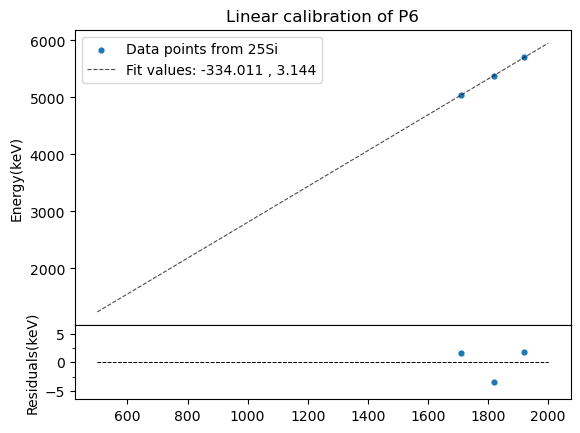

In [8]:
sim_pad_Es = [5046.23, 5380.51, 5703.34]
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0}, sharex=True)
ax1, ax2 = axs
    
popt, _ = sc.curve_fit(lin, x3a, sim_pad_Es)
    
xs = np.linspace(500, 2000)
fitvals = lin(x3a, popt[0], popt[1])
resi = sim_pad_Es-fitvals
ax1.scatter(x3a, sim_pad_Es, s=12, label="Data points from 25Si")
ax1.plot(xs,lin(xs, popt[0], popt[1]), ls='--',color='k', alpha=0.7, lw=0.8,label=f"Fit values: {np.round(popt[1], 3)} , {np.round(popt[0], 3)}")
ax1.set_xlabel("Channel")
ax1.set_ylabel("Energy(keV)")


ax1.set_title(f"Linear calibration of {pad}")
ax1.legend()
    
ax2.hlines(0, 500,2000, color='grey', ls='--', lw=0.7)
ax2.scatter(x3a, resi, s=12)
    #ax2.legend(fontsize='x-small', loc='lower right')
ax2.hlines(0, 500, 2000, ls='--', color='k', lw=0.7) 
ax2.set_yticks(np.arange(-15,15,2.5), minor=True)
ax2.set_ylim(-np.max(np.abs(resi))-3, np.max(np.abs(resi))+3)
ax2.set_ylabel("Residuals(keV)")
print(popt[1], popt[0])
print(resi)
    
#-364.72004274357744 3.496200297901778
#-285.96409610289203 3.0793560775868785
#-314.8331916517445 3.1678775582667975
#-346.640676469352 3.196578063168012

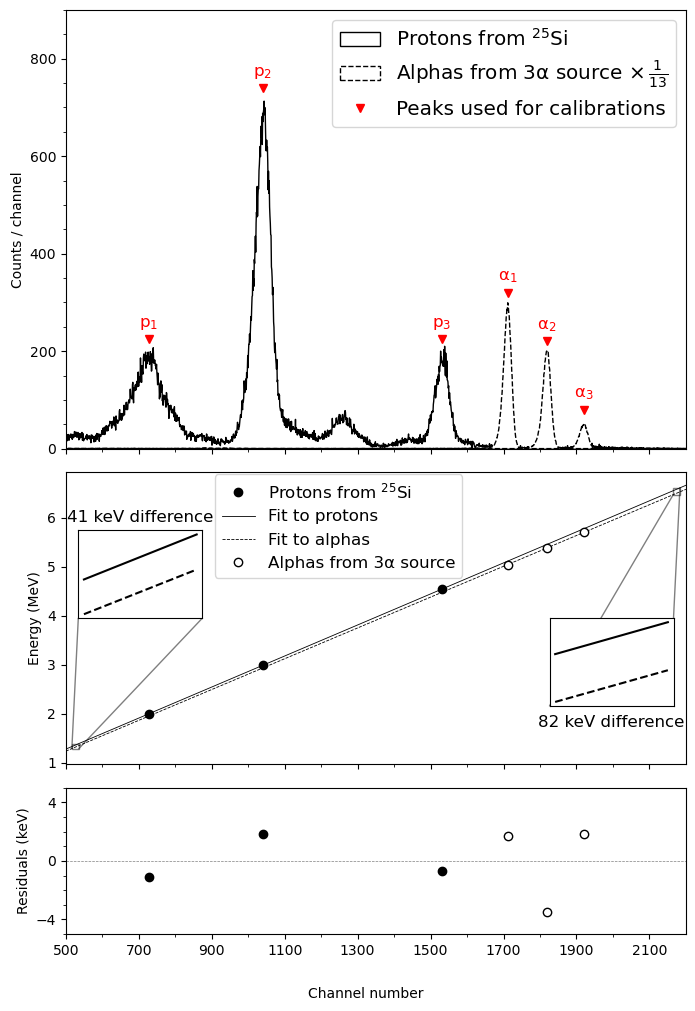

In [14]:

# --- Definitions from your script ---
# These are preserved exactly as you provided them.
xl1_ = 500
xu1_ = 2200
sim_pad_Es = [5046.23, 5380.51, 5703.34]
def lin(x, a, b):
    return a*x + b
def lin_err(x, aerr, berr, aberr):
    return np.sqrt(aerr*x**2* + berr + x*aberr)
# U5F7 alpha 6.827784370976031 3.6347515137514383
# U5F7 alpha [ 1.13010269 -2.32512651  1.19502382]
#U5F7 p -19.90772265800977 3.6715577680429927
# [-1.17159999  1.30635843  4.25521774 -1.45560435  8.98940385  1.67941548 -1.88692107]
XP_ = np.linspace(xl1_, xu1_, 100)
aa_prot = 3.1674153475152966
bb_prot = -304.378816250088
aa_alph = 3.1435126747885684#*1.014
bb_alph = -334.0105837901541#*1.014

#[-1.12399886  1.84169761 -0.71769863]
# The following data variables are assumed to be defined elsewhere in your script:
# x1p_, y1p_, x1a_, y1a_, x3p_, y3p_, x3a_

# --- Create a single 3x1 figure grid ---
# This standard command replaces the custom 'prepare_two_column_figure' function.
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    figsize=(8, 12),  # A reasonable size for a 3x1 vertical layout
    gridspec_kw={'hspace': 0.08, 'height_ratios': [3, 2, 1]}
)

# --- Populate the Top Plot (axes[0]) ---
ax = axes[0]
xpl = np.min(x1p)
xpu = np.max(x1p)

ax.fill_between(x1p, 0, y1p, edgecolor='k', facecolor='w', label='Protons from $^{25}\mathrm{Si}$')
ax.fill_between(x1a[x1a > xl1_ + 5], 0, y1a[x1a > xl1_ + 5]/13, edgecolor='k', facecolor='w', linestyle='--',
                label='Alphas from 3α source $\\times\,\\frac{1}{13}$')

ax.set_yticks(np.arange(0, 900 + 200, 200))
ax.set_yticks(np.arange(0, 900 + 50, 50), minor=True)
ax.set_ylim(0, 900)
#ax.tick_params(labeltop=True) # `sharex=True` handles labelbottom=False automatically
ax.set_ylabel("Counts / channel")

y4p_ = np.array([225, 740, 225])
ax.plot(x3p, y4p_, c='r', ls='', marker='v', label='Peaks used for calibrations')
subs = ["1","2", "3"]
for x, y, sub in zip(x3p, y4p_, subs):
    ax.text(x, y+15, "$\mathrm{p_{%s}}$" % sub, va='bottom', ha='center', c='r', size='large')
y3a_ = [320, 220, 80]
ax.plot(x3a[0:3], y3a_, c='r', ls='', marker='v')
subs = ["1", "2", "3"]
for x, y, sub in zip(x3a[0:3], y3a_, subs):
    ax.text(x, y+15, "$\mathrm{\\alpha_{%s}}$" % sub, va='bottom', ha='center', c='r', size='large')

ax.legend(fontsize='x-large',loc='upper right')

# --- Populate the Middle Plot (axes[1]) ---
ax = axes[1]
ax.plot(x3p, lin(x3p, aa_prot, bb_prot)/1e3, 'ko', label='Protons from $^{25}\mathrm{Si}$')
ax.plot(XP_, lin(XP_, aa_prot, bb_prot)/1e3, 'k-', lw=0.6, label='Fit to protons')
ax.plot(XP_, lin(XP_, aa_alph, bb_alph)/1e3, 'k--', lw=0.6, label='Fit to alphas')
ax.plot(x3a[0:3], lin(x3a[0:3], aa_alph, bb_alph)/1e3, 'ko', markerfacecolor='w', zorder=10,
        label='Alphas from 3α source')

axin1 = ax.inset_axes([0.02, 0.5, 0.20, 0.30])
f1_ = (500 < XP_) & (XP_ < 550)
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_prot, bb_prot)/1e3, 'k-')
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_alph, bb_alph)/1e3, 'k--')
axin1.set_xticks([])
axin1.set_yticks([])
ax.indicate_inset_zoom(axin1, edgecolor="black")
axin1.set_title(f"{int(abs(lin(xl1_,aa_prot,bb_prot)-lin(xl1_,aa_alph,bb_alph)))} keV difference")

axin2 = ax.inset_axes([0.98-0.20, 0.2, 0.20, 0.30])
f2_ = (2150 < XP_) & (XP_ < 2200)
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_prot, bb_prot)/1e3, 'k-')
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_alph, bb_alph)/1e3, 'k--')
axin2.set_xticks([])
axin2.set_yticks([])
ax.indicate_inset_zoom(axin2, edgecolor="black")
axin2.set_title(f"{int(abs(lin(xu1_,aa_prot,bb_prot)-lin(xu1_,aa_alph,bb_alph)))} keV difference", y=-0.34)

ax.set_yticks(np.arange(1, 6, 1), minor=True)
ax.legend(fontsize='large', loc='upper center', bbox_to_anchor=(0.44, 1.02))
ax.set_ylabel("Energy (MeV)")

# --- Populate the Bottom Plot (axes[2]) ---
ax = axes[2]
ax.plot([xl1_, xu1_], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(x3p, [-1.12399886,  1.84169761, -0.71769863], 'ko')
ax.plot(x3a[0:3], [ 1.69825579, -3.51414622 , 1.81589042], 'ko', markerfacecolor='w')
ax.set_ylabel("Residuals (keV)")
ax.set_ylim(-3.5, 3.5)
ax.set_yticks(np.arange(-4, 4 + 4,4))
ax.set_yticks(np.arange(-5, 5 + 1, 1), minor=True)

ax.set_xlim(xl1_, xu1_)
ax.set_xticks(np.arange(500, 2200, 200))
ax.set_xticks(np.arange(500, 2200, 100), minor=True)

# --- Final Figure-level Formatting ---
fig.text(0.5, 0.06, 'Channel number', rotation='horizontal', ha='center', va='center')
plt.savefig("P3comp.pdf", bbox_inches='tight')
plt.show()